In [3]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import pandas as pd
import numpy as np
np.random.seed(0)
from sklearn.model_selection import GridSearchCV, StratifiedKFold  # , cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix  # , classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from scipy import integrate
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support,make_scorer
from sklearn.metrics import confusion_matrix

In [4]:
DATA_PATH = '../data/features/disanto'

disantoFeatures = pd.DataFrame()

for i in range(12):
    temp = pd.read_csv(DATA_PATH+'/'+str(i+1)+'.csv')
    disantoFeatures = pd.concat([disantoFeatures,temp])
    

In [5]:
nondisantoFeatures = pd.DataFrame()

for i in range(12):
    temp = pd.read_csv(DATA_PATH+'/Non'+str(i+1)+'.csv')
    nondisantoFeatures = pd.concat([nondisantoFeatures,temp])

In [6]:
allDisanto = pd.concat([disantoFeatures,nondisantoFeatures])

In [7]:
allDisanto.shape

(62152, 37)

In [8]:
allDisanto= allDisanto.set_index(['ID','copy_num'])

In [9]:
feats = np.array(allDisanto.columns[:-2])
print("Total number of features: {}".format(len(feats)))
print()
print("The features are:")
for i,f in enumerate(feats):
    print("    "+str(i+1)+". " + f)


Total number of features: 33

The features are:
    1. skew
    2. std
    3. kurtosis
    4. beyond1st
    5. stetson_j
    6. stetson_k
    7. max_slope
    8. amplitude
    9. median_absolute_deviation
    10. median_buffer_range_percentage
    11. pair_slope_trend
    12. percent_amplitude
    13. percent_difference_flux_percentile
    14. flux_percentile_ratio_mid20
    15. flux_percentile_ratio_mid35
    16. flux_percentile_ratio_mid50
    17. flux_percentile_ratio_mid65
    18. flux_percentile_ratio_mid80
    19. small_kurtosis
    20. pair_slope_trend_last_30
    21. poly1_t1
    22. poly2_t2
    23. poly2_t1
    24. poly3_t3
    25. poly3_t2
    26. poly3_t1
    27. poly4_t4
    28. poly4_t3
    29. poly4_t2
    30. poly4_t1
    31. magnitudeRatio
    32. lombScargle
    33. rcb


In [10]:
allDisanto['binaryClass'] = list(map(lambda x: 0 if x=='non-transient' else 1, allDisanto.Class))

In [11]:
disantoFeatures = ['amplitude','beyond1st','flux_percentile_ratio_mid20','flux_percentile_ratio_mid35','flux_percentile_ratio_mid50',
                   'flux_percentile_ratio_mid65','flux_percentile_ratio_mid80','poly1_t1','median_absolute_deviation',
                   'median_buffer_range_percentage','max_slope','percent_amplitude',
                   'percent_difference_flux_percentile','pair_slope_trend_last_30','small_kurtosis','skew','std','magnitudeRatio','lombScargle','rcb']
for f in disantoFeatures:
    assert f in allDisanto.columns, 'pailas, {} no esta en las cols'.format(f) 

In [12]:
print(len(disantoFeatures))

20


In [13]:
origtrain = pd.read_pickle('./FixedData/Binary/train.pkl')
origtest = pd.read_pickle('./FixedData/Binary/test.pkl')

In [14]:
train = allDisanto[allDisanto.index.isin(origtrain.index)]
test = allDisanto[allDisanto.index.isin(origtest.index)]

In [15]:
train.shape

(22790, 36)

In [16]:
assert(train.shape[0] == origtrain.shape[0])
assert(test.shape[0] == origtest.shape[0])

# Binary Classification 
Transients and non-transients 

In [17]:
#hypermarameters that gridsearch will optimize
def rf():
    params = {
        'n_estimators': [200, 700],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    return RandomForestClassifier(random_state=0, class_weight='balanced'), params

#metrics to be analized
def scorers():
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average='weighted'),
               'recall': make_scorer(recall_score, average='weighted'),
               'f1_score': make_scorer(f1_score, average='weighted')
               }
    return scoring

In [18]:
allDisanto.binaryClass.unique()


array([1, 0])

In [19]:
#learning 
model,params = rf()
grid_search = GridSearchCV(model, params, cv=StratifiedKFold(2), scoring=scorers(),
                           refit='f1_score', return_train_score=True,verbose=100)
grid_search.fit(train[disantoFeatures], train.binaryClass)

# Copy classifier 
clf = grid_search

#see performance on test set
scores = precision_recall_fscore_support(
        test.binaryClass, clf.predict(test[disantoFeatures]), average='weighted')
recall_scores.append(scores)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=(train=1.000, test=0.913), f1_score=(train=1.000, test=0.913), precision=(train=1.000, test=0.914), recall=(train=1.000, test=0.913), total=   6.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=(train=1.000, test=0.912), f1_score=(train=1.000, test=0.912), precision=(train=1.000, test=0.912), recall=(train=1.000, test=0.912), total=   6.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.2s remaining:    0.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV]  max_features=auto, n_estimators=700, accuracy=(train=1.000, test=0.916), f1_scor

NameError: name 'recall_scores' is not defined

In [20]:
recall_scoresnp = np.array(recall_scores)

print("Precision: {:.4f}".format(np.mean(recall_scoresnp[:,0])))
print("Recall:    {:.4f}".format(np.mean(recall_scoresnp[:,1])))
print("F-score:   {:.4f}".format(np.mean(recall_scoresnp[:,2])))

NameError: name 'recall_scores' is not defined

In [21]:
#calculate feature importance in descending order
importances = clf.best_estimator_.feature_importances_*100
featsCopy = disantoFeatures.copy()

Y = list(importances)
X = list(featsCopy)

yx = list(zip(Y, X))
yx.sort()

yx = yx[::-1]

x_sorted = [x for y, x in yx]
y_sorted = [y for y, x in yx]


In [22]:
importances

array([ 8.25494375,  2.20271499,  1.32586374,  1.46415954,  1.69282231,
        1.71977283,  1.84514267,  8.13064448, 11.11407716,  3.69909507,
        2.54833807,  3.209988  ,  3.43468388,  2.05931132,  4.54877454,
        4.43452939, 14.0154986 ,  8.13112345,  4.108561  , 12.0599552 ])

In [23]:
print(len(disantoFeatures))
print(len(x_sorted))
print(disantoFeatures)

20
20
['amplitude', 'beyond1st', 'flux_percentile_ratio_mid20', 'flux_percentile_ratio_mid35', 'flux_percentile_ratio_mid50', 'flux_percentile_ratio_mid65', 'flux_percentile_ratio_mid80', 'poly1_t1', 'median_absolute_deviation', 'median_buffer_range_percentage', 'max_slope', 'percent_amplitude', 'percent_difference_flux_percentile', 'pair_slope_trend_last_30', 'small_kurtosis', 'skew', 'std', 'magnitudeRatio', 'lombScargle', 'rcb']


In [24]:
 def shorten(x):
    return {
      'stetson_j':'stetson_j',
      'std':'std',
      'median_absolute_deviation':'mad',
      'amplitude':'amp',
      'poly1_t1':'poly1_t1',
      'poly2_t1':'poly2_t1',
      'skew':'skew',
      'poly3_t1':'poly3_t1',
      'small_kurtosis':'sk',
      'stetson_k':'stetson_k',
      'median_buffer_range_percentage':'mbrp',
      'percent_amplitude': 'p_amp',
      'percent_difference_flux_percentile':'pdfp',
      'poly4_t1':'poly4_t1',
      'poly3_t2':'poly3_t2',
      'poly4_t2':'poly4_t2',
      'max_slope':'max_slope',
      'kurtosis':'kurtosis',
      'pair_slope_trend':'pst',
      'poly2_t2':'poly2_t2',
      'beyond1st':'beyond1st',
      'flux_percentile_ratio_mid35':'fpr35',
      'flux_percentile_ratio_mid50':'fpr50',
      'flux_percentile_ratio_mid65':'fpr65',
      'flux_percentile_ratio_mid20':'fpr20',
      'flux_percentile_ratio_mid80':'fpr80',
      'pair_slope_trend_last_30':'pst_last30',
      'poly3_t3':'poly3_t3',
      'poly4_t3':'poly4_t3',
      'poly4_t4':'poly4_t4',
      'magnitudeRatio':'mr',
      'lombScargle':'ls',
      'rcb':'rcb'
      }[x]

In [25]:
#shorten name length
for i,x in enumerate(x_sorted):
    x_sorted[i]=shorten(x)

In [26]:
print(len(x_sorted))

20


In [27]:
x_sorted

['std',
 'rcb',
 'mad',
 'amp',
 'mr',
 'poly1_t1',
 'sk',
 'skew',
 'ls',
 'mbrp',
 'pdfp',
 'p_amp',
 'max_slope',
 'beyond1st',
 'pst_last30',
 'fpr80',
 'fpr65',
 'fpr50',
 'fpr35',
 'fpr20']

20
20


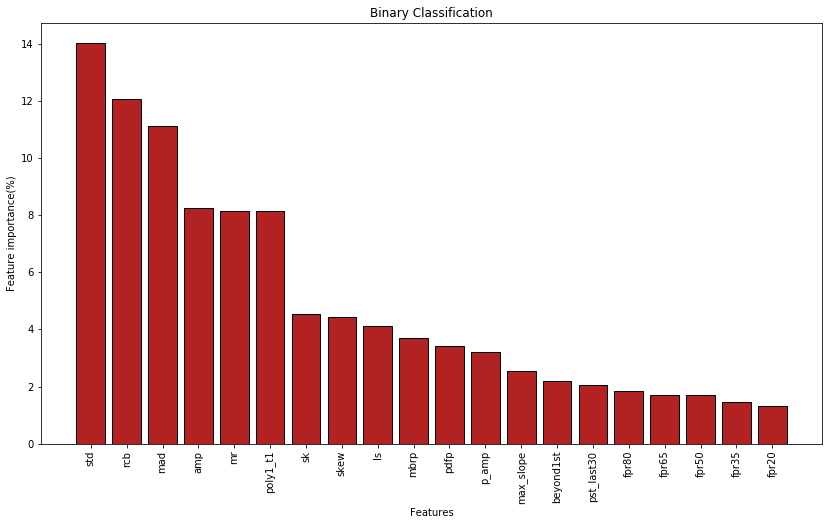

In [29]:

print(len(x_sorted))
print(len(y_sorted))
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(14,8))
plt.gcf().subplots_adjust(bottom=0.15)
plt.bar(np.arange(len(y_sorted)), y_sorted,edgecolor='black',color='firebrick')
plt.xticks(np.arange(len(y_sorted)), x_sorted,rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Feature importance(%)')
plt.title("Binary Classification")
plt.savefig("../results/binFeatImportanceDisanto.pdf")

In [30]:
cm = confusion_matrix(test.binaryClass, clf.predict(test[disantoFeatures])).transpose()
cm

array([[3533,  232],
       [ 265,  835]])

In [31]:
def fMeasure(precision,recall):
    return 2*precision*recall/(precision+recall)

In [32]:
precisionNon = cm[0][0]/(cm[0][0]+cm[0][1])
recallNon = cm[0][0]/(cm[0][0]+cm[1][0])
precisionT = cm[1][1]/(cm[1][1]+cm[1][0])
recallT = cm[1][1]/(cm[1][1]+cm[0][1])

In [33]:
print("Precision of transients:     {:.4f}".format(precisionT))
print("Recall of transients:        {:.4f}".format(recallT))
print("F-measure of transients:     {:.4f}".format(fMeasure(precisionT,recallT)))
print("Precision of non-transients: {:.4f}".format(precisionNon))
print("Recall of non-transients:    {:.4f}".format(recallNon))
print("F-measure of non-transients: {:.4f}".format(fMeasure(precisionNon,recallNon)))


Precision of transients:     0.7591
Recall of transients:        0.7826
F-measure of transients:     0.7707
Precision of non-transients: 0.9384
Recall of non-transients:    0.9302
F-measure of non-transients: 0.9343


# 8-Class clasification

In [34]:
# main 6 transient classes
labels = ['SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare']


In [35]:
# func to map labels to integer values
def manualFact(lab):
    labels = ['SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare','Other','non-transient']
    return labels.index(lab)

In [36]:
origTrain = pd.read_pickle('./FixedData/8Class/train.pkl')
origTest = pd.read_pickle('./FixedData/8Class/test.pkl')

In [37]:
train = origTrain[['target']].merge(allDisanto, left_index=True, right_index=True)
test = origTest[['target']].merge(allDisanto, left_index=True, right_index=True)


In [38]:
assert(train.shape[0] == origTrain.shape[0])
assert(test.shape[0] == origTest.shape[0])

In [39]:
recall_scores = []
model,params = rf()
grid_search = GridSearchCV(model, params, cv=StratifiedKFold(2), scoring=scorers(),
                           refit='f1_score', return_train_score=True,verbose=100)
grid_search.fit(train[disantoFeatures], train.target)
# Copy classifier
clf = grid_search

scores = precision_recall_fscore_support(
        test.target, clf.predict(test[disantoFeatures]), average='weighted')


recall_scores.append(scores)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=(train=1.000, test=0.751), f1_score=(train=1.000, test=0.749), precision=(train=1.000, test=0.749), recall=(train=1.000, test=0.751), total=   5.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=(train=1.000, test=0.756), f1_score=(train=1.000, test=0.754), precision=(train=1.000, test=0.756), recall=(train=1.000, test=0.756), total=   4.8s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.5s remaining:    0.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV]  max_features=auto, n_estimators=700, accuracy=(train=1.000, test=0.757), f1_scor

In [40]:
recall_scoresnp = np.array(recall_scores)

print("Precision: {:.4f}".format(np.mean(recall_scoresnp[:,0])))
print("Recall:    {:.4f}".format(np.mean(recall_scoresnp[:,1])))
print("F-score:   {:.4f}".format(np.mean(recall_scoresnp[:,2])))

Precision: 0.8449
Recall:    0.7367
F-score:   0.7776


In [41]:
confMatr = confusion_matrix(test.target, clf.predict(test[disantoFeatures])).transpose()
print(confMatr)
# 'SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare','Other','non-transient'

[[ 142   20    0    0    6    5   32  103]
 [  22  158    1    1    8    2   14   48]
 [   6    2   92    0    9    1   38   44]
 [   2    1    0   61    0    0    3  160]
 [  12    5    3    0   27    0   10   13]
 [  19    9    1    0    1   22    6  304]
 [  67   16    6    1    6    6  108  154]
 [  53    4    3   13    2   15   23 2972]]


In [42]:
normedMatrix = confMatr.copy()
# print(normedMatrix)
for i in range(len(normedMatrix)):
#     print(normedMatrix[:,i]/normedMatrix[:,i].sum())
    normedMatrix[:,i] = normedMatrix[:,i]/normedMatrix[:,i].sum()
#     print(normedMatrix[:,i])
# np.set_printoptions(suppress=True)
print(normedMatrix)
# np.set_printoptions(suppress=False)

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


In [43]:
newMatr = []
for i in range(len(confMatr)):
    prec = confMatr[i][i]/(sum(confMatr[i,:]))
    rec = confMatr[i][i]/(sum(confMatr[:,i]))
    newMatr.append([prec,rec,fMeasure(prec,rec),sum(confMatr[:,i])])

In [48]:
np.set_printoptions(suppress=True)
print('    Precision        Recall         F-score      Cover')
print(np.array(newMatr))
np.set_printoptions(suppress=False)

    Precision        Recall         F-score      Cover
[[   0.46103896    0.43962848    0.45007924  323.        ]
 [   0.62204724    0.73488372    0.67377399  215.        ]
 [   0.47916667    0.86792453    0.61744966  106.        ]
 [   0.26872247    0.80263158    0.40264026   76.        ]
 [   0.38571429    0.45762712    0.41860465   59.        ]
 [   0.06077348    0.43137255    0.10653753   51.        ]
 [   0.2967033     0.46153846    0.36120401  234.        ]
 [   0.96337115    0.78251711    0.86357693 3798.        ]]


In [49]:
importances = clf.best_estimator_.feature_importances_*100
featsCopy = disantoFeatures.copy()

Y = list(importances)
X = list(featsCopy)

yx = list(zip(Y, X))

yx.sort()
# yx = yx[::-1]
yx = yx[::-1]



x_sorted = [x for y, x in yx]
y_sorted = [y for y, x in yx]


In [50]:
for i,x in enumerate(x_sorted):
    x_sorted[i]=shorten(x)

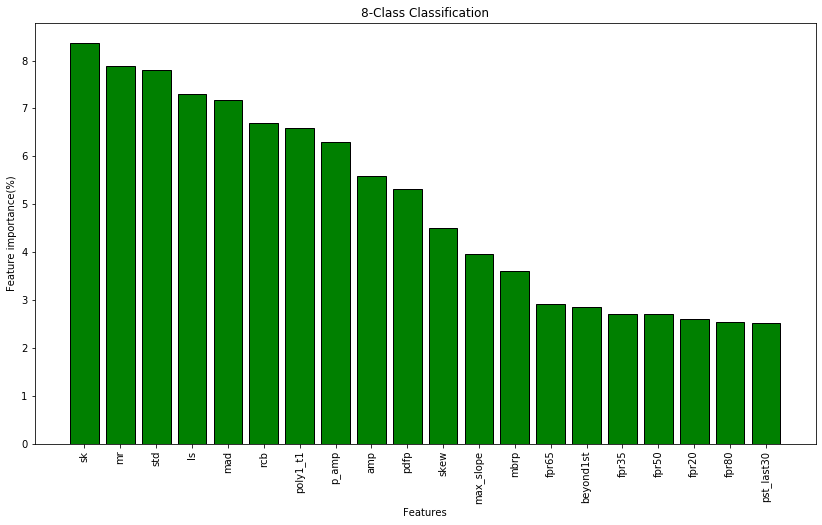

In [52]:
# from matplotlib.font_manager import FontProperties
# font = FontProperties()
# font.set_family('sans-serif')
# font.set_style('normal')

plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(14,8))
plt.gcf().subplots_adjust(bottom=0.15)
plt.bar(np.arange(len(y_sorted)), y_sorted,edgecolor='black',color='#008000')
plt.xticks(np.arange(len(y_sorted)), x_sorted,rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Feature importance(%)')
plt.title("8-Class Classification")
plt.savefig("../results/8clasFeatImportanceDisanto.pdf")